# BME280 Sensor Analysis Session
Welcome to the BME280 sensor data analysis session using python

In [1]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
import cartopy
import datetime
from datetime import datetime

Read in appropriate files and datasets. Change "Test.csv" for locally saved names.

In [2]:
# Read in files
file = open("Test.csv")
gps_file = open("gps.csv")

# Open files as datasets
dataset = pd.read_csv(file)
gps_data = pd.read_csv(gps_file)


We need to merge the datasets due to not recording GPS on the sensors, we will also have to make some data conversions to make plotting and analysis easier:

Need to convert datetime columns to datetime objects:
Converts into the format: dd/mm/yyyy hh:mm:ss

In [3]:
dataset["date"] = pd.to_datetime(dataset['date'], format='%d/%m/%Y %H:%M:%S')
gps_data["gps_datetime"] = pd.to_datetime(gps_data['gps_datetime'], format='%d/%m/%Y %H:%M:%S')


We now need to sort the data to ensure it is chronological order:

In [4]:
dataset_sorted = dataset.sort_values('date')
gps_data_sorted = gps_data.sort_values('gps_datetime')

Merge through by matching nearest datetime values. This tags the latitude and longitude columns onto your data array

In [5]:
data = pd.merge_asof(dataset_sorted, gps_data_sorted, left_on='date', right_on='gps_datetime', direction='nearest')

We can extract time from our datetime data if we are interested in daily cycles:

In [6]:
data['time'] = data['date'].dt.time

We also need to convert the time into plottable numeric data:

In [7]:
data['time_numeric'] = data['time'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

# Daily mean data
Doing the same as we did for time but for date allows us to compute daily means etc.

In [8]:
# Do the same for date:
data['day'] = data['date'].dt.date

In [9]:
# We can now calculate the mean temperature, etc. of our data by grouping by the day it was measured on:
day_temp = data.groupby('day')['temperature'].mean()
# This returns a series with the index being the day and the values are the temperatures
day_humid = data.groupby('day')['humidity'].mean()
day_pressure = data.groupby('day')['pressure'].mean()

# Figure Plotting:
We'll start with some simple timeseries plots:

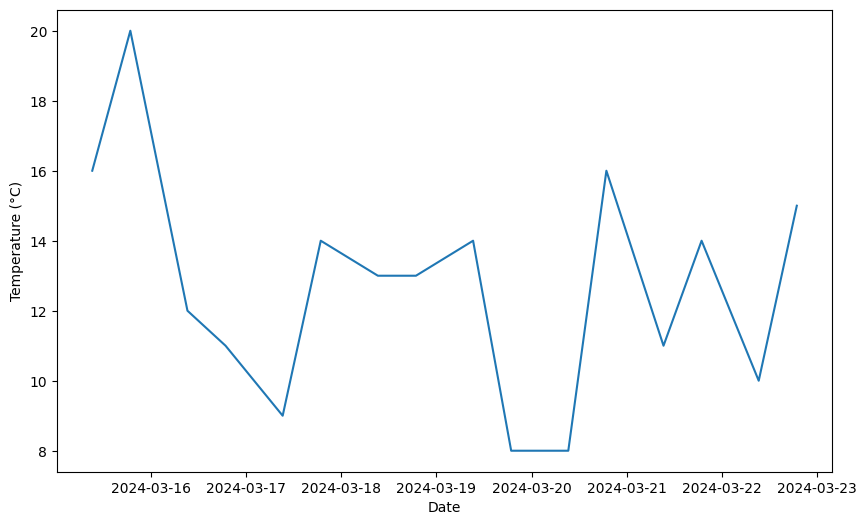

In [10]:
# This figure plots a timeseries of temperature
# Start figure
plt.figure(figsize=(10,6))
# Tell it what to plot
plt.plot(data['date'], data['temperature'])
# Label axes
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()


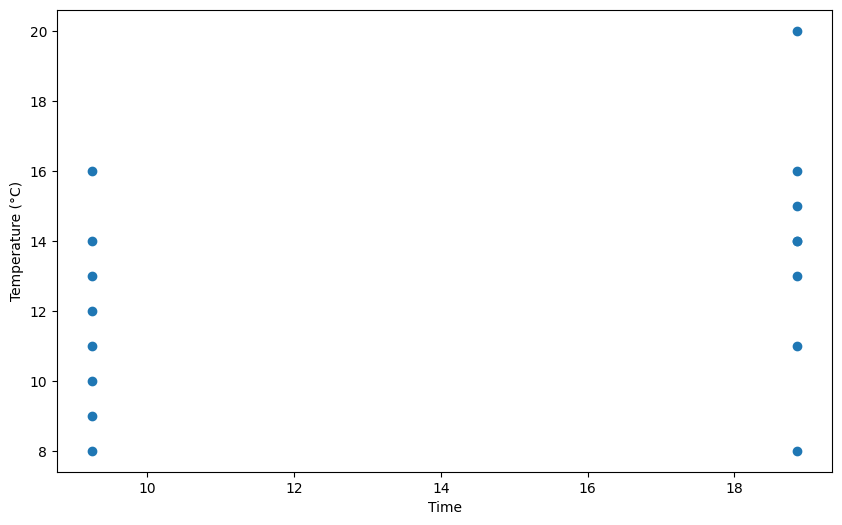

In [11]:
# This figure plots a timeseries of temperature but with the day component removed
# Start figure
plt.figure(figsize=(10,6))
# We can change the type of plot if necessary: (I've changed this one to a scatter)
plt.scatter(data['time_numeric'], data['temperature'])
# Label axes
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()

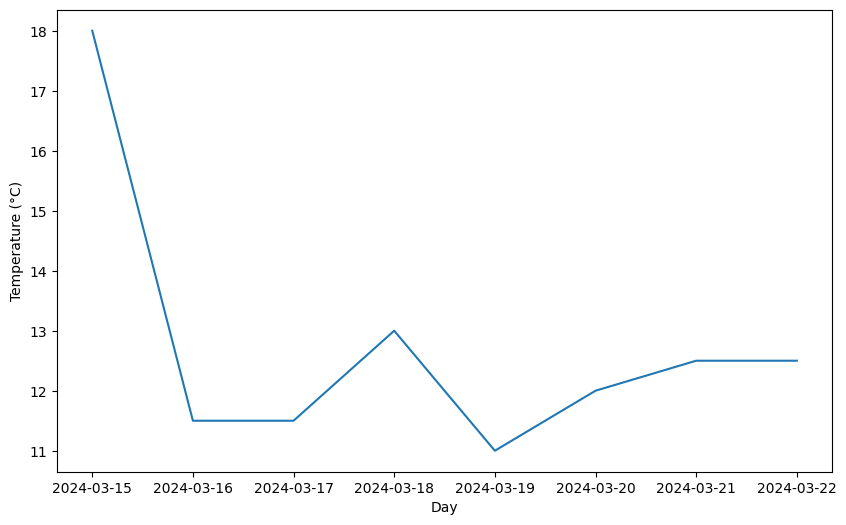

In [12]:
# This figure plots a timeseries of temperature but as a daily mean
# Start figure
plt.figure(figsize=(10,6))
# tell it what to plot
plt.plot(day_temp.index, day_temp)
# label axes
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
# to save the figure, delete the hashtag, re-run and change name from timeseries.png
# plt.savefig('timeseries.png', dpi = 300)
plt.show()


# Maps:

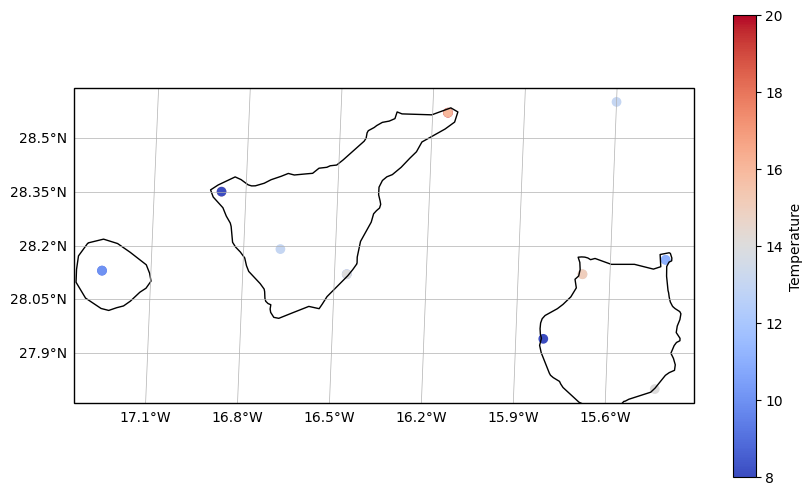

In [13]:
# This figure maps temperature data on a scatterplot for our fieldwork
# Start figure
plt.figure(figsize=(10, 6))
# Setup axes with map projection
ax = plt.axes(projection = cartopy.crs.Robinson())
# Add coastlines
ax.coastlines(resolution = '10m')
# Add scattered data
sc = ax.scatter(data['longitude'], data['latitude'], c= data['temperature'], cmap = 'coolwarm', marker = 'o', transform = cartopy.crs.PlateCarree())
# Setup colorbar
cbar = plt.colorbar(sc, ax = ax, label = 'Temperature')
# Figure outline
ax.spines['geo'].set_linewidth(1)
# Setup gridlines
gl = ax.gridlines(linewidth=0.5, draw_labels=True, crs=cartopy.crs.PlateCarree())
# Remove right side and top of figure labels
gl.right_labels = False
gl.top_labels = False
# to save the figure, delete the hashtag and re-run
# plt.savefig('map.png', dpi = 300)
plt.show()